# Cell Depth

Notebook for invesitgating psf_maglim depth of cell-based coadds.

## Load in imports and data

Last working stack: `d_2024_08_27`

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import gc

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

In [2]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_d_2024_08_27/20240904T143002Z'

In [3]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

In [4]:
# generate list of patches within defined tract

tract = 9813

patches = []
# look for deepCoaddCell objects rather than input warps
# since some patches may fail and not produce coadds, but still have all warps in collection
for ref in butler.registry.queryDatasets('deepCoaddCell',
                                         physical_filter='HSC-I',
                                         collections=collection,
                                         instrument='HSC',
                                         skymap = 'hsc_rings_cells_v1',
                                         where=f'tract={tract}'):
    patches.append(ref.dataId.get('patch'))
patches = np.unique(patches)

## Cell Depth Methods

Example calculations for values needed to calculate cell cepth.

Image depth equation from https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/healSparseMappingProperties.py#L485

In [5]:
# returns effective PSF area given the PSF stamp image array
def psfArea(psf_im):
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but possibly prone to changing PSF area if stamp size changes
    denom = np.sum(np.square(psf_im))
    return numer/denom

In [6]:
# returns the total weight of a cell, given the cell object and statistics settings
def cell_weight(cell, statsCtrl):
    accTask = AssembleCellCoaddTask()
    mask_im = cell.outer.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    # the computed weight will be the same value for each pixel
    total_weight = computed_weight * mask_im.getDimensions()[0] * mask_im.getDimensions()[1]
    return total_weight

In [7]:
# returns the limiting PSF magnitude of each pixel, given the effective PSF area and total cell weight
def mag_lim(psf_area, weights, zp=27, num_sigma=5):
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/weights))
    return maglim

It's generally more useful to call only one method when calculating the cell depth, but the smaller methods can be useful for testing.

In [8]:
# returns the limiting PSF magnitude of each pixel, given the cell object and statistics settings
def get_mag_lim(cell, statsCtrl, zp=27, num_sigma=5):
    
    # get psf area of cell
    psf_im = cell.psf_image.array
    numer = np.square(np.sum(psf_im))
    # numer = 1 # I've seen this as well, but said to be prone to changing if stamp size changes
    denom = np.sum(np.square(psf_im))
    psf_area = numer/denom

    # get cell weight
    accTask = AssembleCellCoaddTask()
    mask_im = cell.outer.asMaskedImage()
    computed_weight = accTask._compute_weight(mask_im, statsCtrl)
    # the computed weight will be the same value for each pixel
    total_weight = computed_weight * mask_im.getDimensions()[0] * mask_im.getDimensions()[1]
    
    # get the limiting magnitude
    maglim = zp-2.5*np.log10(num_sigma*np.sqrt(psf_area/total_weight))
    
    return maglim

## Single Patch

Calculate the PSF maglim for each cell in a patch.

In [9]:
patch = 50

In [10]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [11]:
cell_list_filled = list(coadd.cells.keys()) # list of non-empty cells

In [12]:
# generate all possible cell indices within a 2D arary

cell_list = []
cells_filled = [False] * coadd.grid.shape[0] * coadd.grid.shape[1]

index = 0 
for i in range(coadd.grid.shape[0]):
    for j in range(coadd.grid.shape[1]):
        # Index2D axes are reverse of 2D list
        cell_list.append(Index2D(x=j,y=i))

        if Index2D(x=j,y=i) in cell_list_filled:
            cells_filled[index]=True

        index += 1

In [13]:
# arrange the number of inputs for each cell into a 2D grid:

x_cell_bin = np.arange(0,coadd.grid.shape[0]+1,1)
y_cell_bin = np.arange(0,coadd.grid.shape[1]+1,1)

inputs_list = np.zeros([coadd.grid.shape[0],coadd.grid.shape[1]])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

Example methods on test cell:

In [14]:
depth_cell = coadd.cells[Index2D(x=21,y=21)]
depth_psf_image = depth_cell.psf_image.array
psf_area = psfArea(depth_psf_image)
print("PSF eff. area: ", psf_area)
print("Cell totaled weights: ", cell_weight(depth_cell, statsCtrl))
print("Cell depth: ", np.mean(mag_lim(psf_area, cell_weight(depth_cell, statsCtrl))))

PSF eff. area:  42.581625950774836
Cell totaled weights:  388.0925415679518
Cell depth:  26.452216308921326


### Cell Depth 2D Distribution

In [15]:
cell_depths = np.empty([coadd.grid.shape[0],coadd.grid.shape[1]])

for index, cell_index in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 

    cell = coadd.cells[cell_index]
    psf_im = cell.psf_image.array

    psf_area = psfArea(psf_im)
    weight = cell_weight(cell, statsCtrl)
    
    cell_depth = mag_lim(psf_area, weight)

    x_index = cell_index.x
    y_index = cell_index.y
    
    cell_depths[y_index][x_index] = cell_depth

# mask empty cells
cell_depths = ma.masked_where(cell_depths < 0.1, cell_depths) # TO-DO: remove hard coded condition

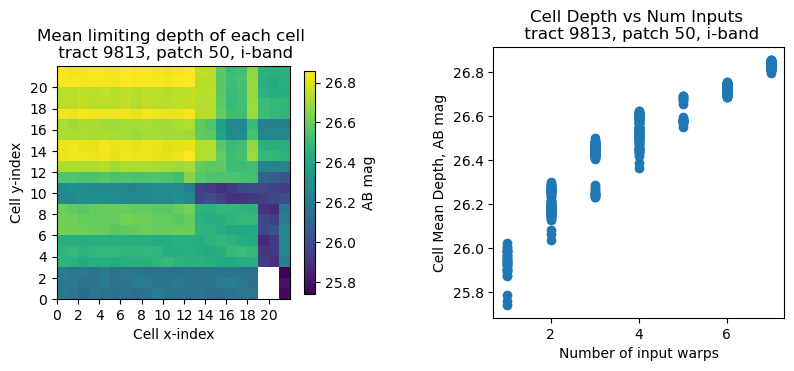

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

depths = axs[0].pcolormesh(cell_depths, 
                        shading='auto', 
                        vmin=ma.min(cell_depths), 
                        vmax=ma.max(cell_depths),)

axs[0].set_title(f"Mean limiting depth of each cell \n tract 9813, patch {patch}, i-band")
axs[0].set_xlabel("Cell x-index")
axs[0].set_ylabel("Cell y-index")
axs[0].set_aspect('equal')
axs[0].set_xticks(np.arange(0, 21, 2))
axs[0].set_yticks(np.arange(0, 21, 2))
fig.colorbar(depths, ax=axs[0], cmap='viridis', shrink=0.3, label='AB mag')

depths = axs[1].scatter(inputs_list.flatten(), cell_depths)

# a rough estimate of the theoretical improvement in depth
xs = np.linspace(1, 7, 1000)
ys = 1.25*np.log10(xs)+25.8
#log_funtion = axs[1].plot(xs, ys)

axs[1].set_title(f"Cell Depth vs Num Inputs \n tract 9813, patch {patch}, i-band")
axs[1].set_aspect(12)
axs[1].set_xlabel("Number of input warps")
axs[1].set_ylabel("Cell Mean Depth, AB mag")
axs[1].set_aspect(5)

Fortunately, the limiting depth seems to improve as number of input images increases. This should be tested on a wider range of cells.

## Multiple Patches

Calculate the PSF maglim for each cell in a tract.

This will only be generating the scatter plot distribution. For a visual map of cell depth, check out the `healsparse-plots.ipynb` notebook.

In [17]:
# find total number of non-empty cells within the tract

cell_count = 0
for patch in patches:
    coadd = butler.get('deepCoaddCell', 
                         collections=collection, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)

    cells = len(list(coadd.cells.keys())) # get number of non-empty cells
    cell_count += cells
    del coadd
    gc.collect()
print("Number of cells: ", cell_count)

Number of cells:  7657


In [18]:
# collect cell info
cell_df = pd.DataFrame()
inputs_list = []
mag_depth_list = []
center_ra = []
center_dec = []

for patch in patches:
    
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=patch,
                     band='i',)

    wcs = coadd.wcs
    
    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    # for each cell in cell_list:
    for index, cell_index in enumerate(cell_list):

        cell = coadd.cells[cell_index]

        cell_center = cell.outer.bbox.getCenter()
        cell_center_coord = wcs.pixelToSky(cell_center)
        center_ra.append(cell_center_coord[0].asDegrees())
        center_dec.append(cell_center_coord[1].asDegrees())
        
        inputs_list.append(cell.visit_count)
        mag_depth_list.append(get_mag_lim(cell, statsCtrl))

    del coadd
    gc.collect()

cell_df["inputs"] = inputs_list
cell_df["depth"] = mag_depth_list
cell_df["center_ra"] = center_ra
cell_df["center_dec"] = center_dec

In [19]:
cell_df = cell_df.drop_duplicates(subset=['center_ra', 'center_dec']) # remove overlapping cells due to patch overlap

Plot the relationship between the number of input warps for a cell, and the calculated depth. Jittering is added to avoid overplotting of data points.

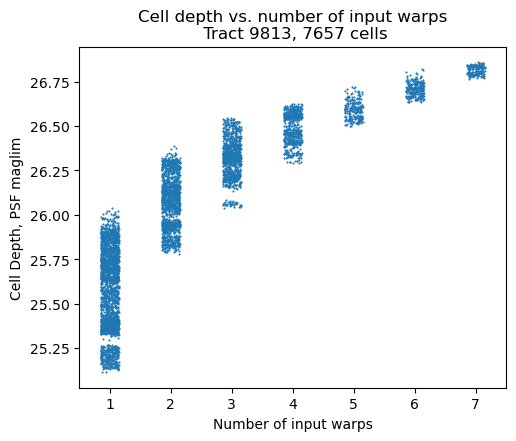

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))
plt.tight_layout()

depths = sns.stripplot(data=cell_df, x="inputs", y="depth", jitter=0.15, size=1.5)

axs.set_title(f"Cell depth vs. number of input warps\n Tract 9813, {cell_count} cells")
axs.set_xlabel("Number of input warps")
axs.set_ylabel("Cell Depth, PSF maglim")
plt.savefig('image_outputs/depth-vs-inputs.png', bbox_inches='tight')
plt.show()

Get the average depth for each number of inputs warps.

In [21]:
# list of possible inputs
input_types = np.sort(cell_df.inputs.unique())

In [22]:
mean_depth = []
median_depth = []

for input_type in input_types:
    
    cell_input_df = cell_df.where(cell_df.inputs == input_type, inplace=False)
    mean_depth.append(cell_input_df.depth.mean())
    median_depth.append(cell_input_df.depth.median())

Plot the average of each input bin compared to the very rough theoretical relationship. Note that the intercept is chosen from the mean data of the first bin.

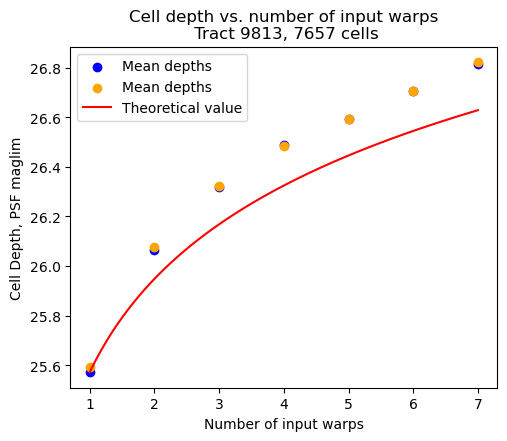

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))
plt.tight_layout()

mean_depths = axs.scatter(input_types, mean_depth, color='blue', label='Mean depths')
median_depths = axs.scatter(input_types, median_depth, color='orange', label='Mean depths')

# a (very) rough estimate of the theoretical improvement in depth
xs = np.linspace(1, input_type.max(), 1000)
ys = 1.25*np.log10(xs) + mean_depth[0]
log_funtion = axs.plot(xs, ys, color='red', label='Theoretical value')

axs.set_title(f"Cell depth vs. number of input warps\n Tract 9813, {cell_count} cells")
axs.set_xlabel("Number of input warps")
axs.set_ylabel("Cell Depth, PSF maglim")
plt.legend()
plt.savefig('image_outputs/depth-vs-inputs.png', bbox_inches='tight')
plt.show()

There appears to be a slight inconsistency between 1 input and the rest of the inputs. Could see how this behaves with a different tract or multiple tracts combined.

### Tract 9697

In [24]:
collection_9697 = 'u/mgorsuch/cell_coadds_tract_9697_34/20240920T185131Z'

In [25]:
# generate list of patches within defined tract

tract = 9697

patches = []
# look for deepCoaddCell objects rather than input warps
# since some patches may fail and not produce coadds, but still have all warps in collection
for ref in butler.registry.queryDatasets('deepCoaddCell',
                                         physical_filter='HSC-I',
                                         collections=collection_9697,
                                         instrument='HSC',
                                         skymap = 'hsc_rings_cells_v1',
                                         where=f'tract={tract}'):
    patches.append(ref.dataId.get('patch'))
patches = np.unique(patches)

In [26]:
# find total number of non-empty cells within the tract

cell_count = 0
for patch in patches:
    coadd = butler.get('deepCoaddCell', 
                         collections=collection_9697, 
                         instrument='HSC', 
                         skymap = 'hsc_rings_cells_v1', 
                         tract = tract, 
                         patch=patch,
                         band='i',)

    cells = len(list(coadd.cells.keys())) # get number of non-empty cells
    cell_count += cells
    del coadd
    gc.collect()
print("Number of cells: ", cell_count)

Number of cells:  19180


In [27]:
# collect cell info
cell_df = pd.DataFrame()
inputs_list = []
mag_depth_list = []
center_ra = []
center_dec = []

for patch in patches:
    
    coadd = butler.get('deepCoaddCell', 
                     collections=collection_9697, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = tract, 
                     patch=patch,
                     band='i',)

    wcs = coadd.wcs
    
    cell_list = list(coadd.cells.keys()) # skips indices that are empty

    # for each cell in cell_list:
    for index, cell_index in enumerate(cell_list):

        cell = coadd.cells[cell_index]

        cell_center = cell.outer.bbox.getCenter()
        cell_center_coord = wcs.pixelToSky(cell_center)
        center_ra.append(cell_center_coord[0].asDegrees())
        center_dec.append(cell_center_coord[1].asDegrees())
        
        inputs_list.append(cell.visit_count)
        mag_depth_list.append(get_mag_lim(cell, statsCtrl))

    del coadd
    gc.collect()

cell_df["inputs"] = inputs_list
cell_df["depth"] = mag_depth_list
cell_df["center_ra"] = center_ra
cell_df["center_dec"] = center_dec

In [28]:
cell_df = cell_df.drop_duplicates(subset=['center_ra', 'center_dec']) # remove overlapping cells due to patch overlap

In [29]:
# list of possible inputs
input_types = np.sort(cell_df.inputs.unique())

In [30]:
mean_depth = []
median_depth = []

for input_type in input_types:
    
    cell_input_df = cell_df.where(cell_df.inputs == input_type, inplace=False)
    mean_depth.append(cell_input_df.depth.mean())
    median_depth.append(cell_input_df.depth.median())

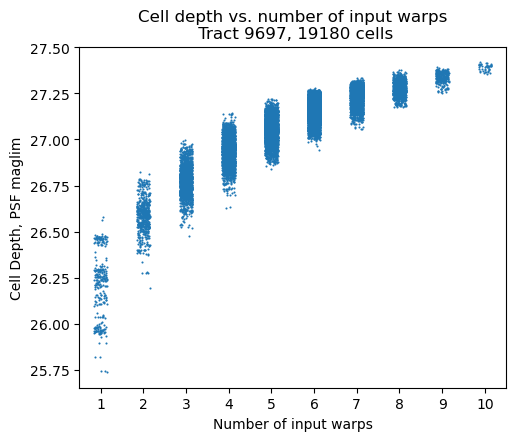

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))
plt.tight_layout()

depths = sns.stripplot(data=cell_df, x="inputs", y="depth", jitter=0.15, size=1.5)

axs.set_title(f"Cell depth vs. number of input warps\n Tract {tract}, {cell_count} cells")
axs.set_xlabel("Number of input warps")
axs.set_ylabel("Cell Depth, PSF maglim")
plt.savefig('image_outputs/depth-vs-inputs.png', bbox_inches='tight')
plt.show()

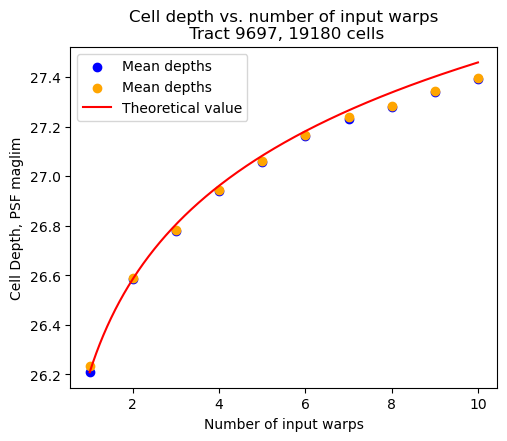

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))
plt.tight_layout()

mean_depths = axs.scatter(input_types, mean_depth, color='blue', label='Mean depths')
median_depths = axs.scatter(input_types, median_depth, color='orange', label='Mean depths')

# a (very) rough estimate of the theoretical improvement in depth
xs = np.linspace(1, input_type.max(), 1000)
ys = 1.25*np.log10(xs) + mean_depth[0]
log_funtion = axs.plot(xs, ys, color='red', label='Theoretical value')

axs.set_title(f"Cell depth vs. number of input warps\n Tract {tract}, {cell_count} cells")
axs.set_xlabel("Number of input warps")
axs.set_ylabel("Cell Depth, PSF maglim")
plt.legend()
plt.savefig('image_outputs/depth-vs-inputs.png', bbox_inches='tight')
plt.show()

The fit is generally better, which indicates that a larger number of cells with inputs will improve the comparison to the theoretical model.